In [22]:
# Import libraries
import os
import glob
import pydicom as dicom
import numpy as np
import pandas as pd
import cv2

In [23]:
import torch
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.applications import InceptionResNetV2
from keras.utils import plot_model

In [24]:
# Import custom definitions
from definitions import *

print(f"Dataset path: {data_root}")
print(f"Meta path: {meta_path}")
print(f"Mass training data path: {new_mass_train_path}")
print(f"Mass test data path: {new_mass_test_path}")

Dataset path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688
Meta path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\metadata.csv
Mass training data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_train_set.csv
Mass test data path: C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\new_mass_case_description_test_set.csv


# datasets

In [25]:
# Load updated mass datasets
new_mass_train = pd.read_csv(new_mass_train_path)
new_mass_test = pd.read_csv(new_mass_test_path)

In [28]:
new_mass_train.head(2)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC\07-20-2016-DDSM-...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...,Mass-Training_P_00001_LEFT_CC_1\07-21-2016-DDS...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO\07-20-2016-DDSM...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...,Mass-Training_P_00001_LEFT_MLO_1\07-21-2016-DD...


In [29]:
new_mass_test.head(2)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC\10-04-2016-DDSM-NA-3...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...,Mass-Test_P_00016_LEFT_CC_1\10-04-2016-DDSM-NA...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO\10-04-2016-DDSM-NA-...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...,Mass-Test_P_00016_LEFT_MLO_1\10-04-2016-DDSM-N...


### Extract pixel data from dicom files

In [145]:
def image_processor(image_path, target_size):
    path = os.path.join(data_root,'CBIS-DDSM', image_path)
    ds = dicom.dcmread(path)
    ds = ds.pixel_array
    ds_2d = ds.astype(float)
    ds_2d_scaled = (np.maximum(ds_2d, 0) / ds_2d.max()) * 255.0
    ds_2d_scaled = np.uint8(ds_2d_scaled)
    ds_2d_scaled = cv2.cvtColor(ds_2d_scaled, cv2.COLOR_BGR2RGB)
    ds_resized = tf.image.resize(ds_2d_scaled, (128, 128), method="nearest")
    ds_cast = tf.cast(ds_resized, tf.float32) / 255.0
    return ds_cast

def mask_processor(image_path, target_size):
    path = os.path.join(data_root,'CBIS-DDSM', image_path)
    ds = dicom.dcmread(path)
    ds = ds.pixel_array
    ds_2d = ds.astype(float)
    ds_2d_scaled = (np.maximum(ds_2d, 0) / ds_2d.max()) * 255.0
    ds_2d_scaled = np.uint8(ds_2d_scaled)
    ds_2d_scaled = cv2.cvtColor(ds_2d_scaled, cv2.COLOR_BGR2RGB)
    ds_resized = tf.image.resize(ds_2d_scaled, (128, 128), method="nearest")
    ds_cast = ds_resized - 1
    return ds_cast
    
def load_image(input_image, input_mask, target_size):
    input_image = image_processor(input_image, target_size)
    input_mask = mask_processor(input_mask, target_size)
    return input_image, input_mask

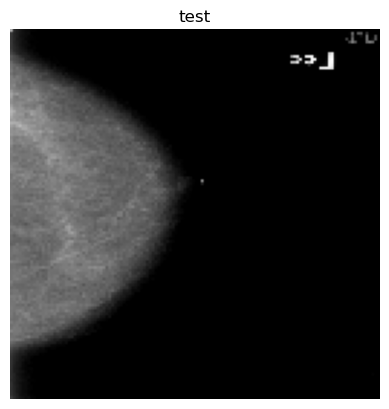

(128, 128, 3) <dtype: 'float32'>


In [146]:
# Test
import matplotlib.pyplot as plt

path = r"C:\Users\lejam\Desktop\CBIS-DDSM\manifest-1748122768688\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-2017-DDSM-NA-96009\1.000000-full mammogram images-63992\1-1.dcm"
test_data = image_processor(path, target_size)

plt.subplot(1, 1, 1)
plt.title('test')
plt.imshow(tf.keras.utils.array_to_img(test_data))
plt.axis("off")
plt.show()

print(test_data.shape, test_data.dtype)

In [147]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
BATCH = 2

In [190]:
#test_train = new_mass_train[:3]
train_images = tf.data.Dataset.from_tensor_slices((
    list(map(lambda x: image_processor(x, target_size), new_mass_train['image file path'])),
    list(map(lambda x: image_processor(x, target_size), new_mass_train['ROI mask file path']))
))

In [191]:
for x, y in train_images.take(1): print(x.shape)

(128, 128, 3)


In [192]:
test_images = tf.data.Dataset.from_tensor_slices((
    list(map(lambda x: image_processor(x, target_size), new_mass_test['image file path'])),
    list(map(lambda x: image_processor(x, target_size), new_mass_test['ROI mask file path']))
))#.batch(BATCH)

In [193]:
for x, y in test_images.take(1): print(x.shape)

(128, 128, 3)


In [194]:
train_batches = train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_images.take(3000).batch(BATCH_SIZE)
test_batches = test_images.skip(3000).take(669).batch(BATCH_SIZE)

In [153]:
#torch.save(train_images, mass_train_tensor_path)

In [154]:
#torch.save(test_images, mass_test_tensor_path)

In [155]:
#mass_train_torch = torch.load(mass_train_tensor_path)

In [156]:
#mass_test_torch = torch.load(mass_test_tensor_path)

# CNN Architecture

### Model architecture and training

In [179]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x
    
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same", activation="relu")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [180]:
def build_modified_unet_model():
    model = None
    try:
        inputs = layers.Input(shape=target_size)
    
        f = [64, 128, 256, 512, 1024]
    
        # Encoder - Downsampling path
        f1, p1 = downsample_block(inputs, f[0])
        f2, p2 = downsample_block(p1, f[1])
        f3, p3 = downsample_block(p2, f[2])
        f4, p4 = downsample_block(p3, f[3])
    
        # Bottleneck
        bottleneck = double_conv_block(p4, f[4])
    
        # Decoder - Upsampling path
        u6 = upsample_block(bottleneck, f4, f[3])
        u7 = upsample_block(u6, f3, f[2])
        u8 = upsample_block(u7, f2, f[1])
        u9 = upsample_block(u8, f1, f[0])
    
        # Output layer
        outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)
    
        # Model
        model = tf.keras.Model(inputs, outputs, name="U-Net")
    except Exception as ex:
        print(f"\nError caught: {ex}")
    finally:
        return model

In [195]:
model = build_modified_unet_model()

In [196]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy", # sparse_categorical_crossentropy
    metrics=["accuracy"])

In [199]:
NUM_EPOCHS = 1
TRAIN_LENGTH = new_mass_train.shape[0]
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = new_mass_test.shape[0]
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

print(f"epochs: {NUM_EPOCHS}")
print(f"train length: {TRAIN_LENGTH}")
print(f"steps per epoch: {STEPS_PER_EPOCH}")
print(f"val subsplits: {VAL_SUBSPLITS}")
print(f"test length: {TEST_LENTH}")
print(f"validation steps: {VALIDATION_STEPS}")

epochs: 1
train length: 1318
steps per epoch: 20
val subsplits: 5
test length: 378
validation steps: 1


In [200]:
model_history = model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches)

14/20 ━━━━━━━━━━━━━━━━━━━━ 2:14 22s/step - accuracy: 1.0000 - loss: nan

KeyboardInterrupt: 